# Práctica NLP


Imports necesarios:

In [33]:
import pandas as pd
import gzip
import json
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

## Descarga y exploración del corpus

Descargo de Amazon Review Data 2018 del link "https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/" en el apartado "Small" subsets for experimentation la categoría de Video Games ya que el otro es un json muy grande y ralentiza todos los procesos en mi ordenador

In [2]:
df = pd.read_json("Video_Games_5.json.gz", lines=True, compression="gzip")

Analizamos las columnas del Dataset

In [3]:
print(df.columns)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         497577 non-null  int64 
 1   verified        497577 non-null  bool  
 2   reviewTime      497577 non-null  object
 3   reviewerID      497577 non-null  object
 4   asin            497577 non-null  object
 5   reviewerName    497501 non-null  object
 6   reviewText      497419 non-null  object
 7   summary         497468 non-null  object
 8   unixReviewTime  497577 non-null  int64 
 9   vote            107793 non-null  object
 10  style           289237 non-null  object
 11  image           3634 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 42.2+ MB


Veo que las columnas "image, style, vote" no son muy relevantes ya que están en su mayoria vacías

In [5]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,497567,497568,497569,497570,497571,497572,497573,497574,497575,497576
overall,5,4,3,2,5,4,1,5,5,4,...,5,5,4,3,5,4,3,3,4,2
verified,True,False,True,True,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,False,True
reviewTime,"10 17, 2015","07 27, 2015","02 23, 2015","02 20, 2015","12 25, 2014","11 13, 2014","08 2, 2014","03 3, 2014","02 21, 2014","06 27, 2013",...,"09 18, 2017","06 19, 2017","05 28, 2017","05 20, 2017","07 1, 2017","07 1, 2017","08 20, 2018","08 7, 2017","08 5, 2018","03 13, 2018"
reviewerID,A1HP7NVNPFMA4N,A1JGAP0185YJI6,A1YJWEXHQBWK2B,A2204E1TH211HT,A2RF5B5H74JLPE,A11V6ZJ2FVQY1D,A1KXJ1ELZIU05C,A1WK5I4874S3O2,AV969NA4CBP10,A1EO9BFUHTGWKZ,...,A1O3GR0TMQEVU8,AVOS4AN9YUGCL,A3P0CBZ9GCL0OU,A3JLLK1KJFD3BN,A2NKYXCAGBGW7F,AVECM71LSZLC5,A1RS06313BL6WN,ACIZ77IGIX2JL,A34GG58TJ1A3SH,A6W81WTFK940B
asin,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,...,B01HFRICLE,B01HFRICLE,B01HFRICLE,B01HFRICLE,B01HGPUTCA,B01HGPUTCA,B01HH6JEOC,B01HH6JEOC,B01HIZF7XE,B01HIZGKOE
reviewerName,Ambrosia075,travis,Vincent G. Mezera,Grandma KR,jon,IBRAHIM ALBADI,Creation27,WhiteSkull,Travis B. Moore,johnnyz3,...,armyjackson,Jim Y,Anfotero,A. Lai,Snipun1,boris teplitskiy,Tom Stopsign,Era,seamonkey10,msam420
reviewText,"This game is a bit hard to get the hang of, bu...",I played it a while but it was alright. The st...,ok game.,"found the game a bit too complicated, not what...","great game, I love it and have played it since...",i liked a lot some time that i haven't play a ...,"I'm an avid gamer, but Anno 2070 is an INSULT ...",I bought this game thinking it would be pretty...,I have played the old anno 1701 AND 1503. thi...,"I liked it and had fun with it, played for a w...",...,This is the RIver City Ransom sequel that I've...,If you played and enjoyed River City Ransom on...,Old school classic,This nostalgic game with updaged game play ele...,"This Work Great and easy to replace, I would n...",not OEM but good replacement parts,Okay stuff.,This does add some kids room things that are v...,I think I originally began playing Bioshock se...,"The graphics are terrible, it looks like ps2 g..."
summary,but when you do it's great.,"But in spite of that it was fun, I liked it",Three Stars,Two Stars,love this game,Anno 2070,Avoid This Game - Filled with Bugs,A very good game balance of skill with depth o...,Anno 2070 more like anno 1701,Pretty fun,...,it has the Dodgeball yard from Super Dodgeball...,Nostalgic Fun,Four Stars,"special moves) looks great, plays awesome but ...",I plan on doing all my controllers this way now,Four Stars,Three Stars,Only buy on sale.,"It's Okay, Nothing Profound",Not as good as I expected it to be
unixReviewTime,1445040000,1437955200,1424649600,1424390400,1419465600,1415836800,1406937600,1393804800,1392940800,1372291200,...,1505692800,1497830400,1495929600,1495238400,1498867200,1498867200,1534723200,1502064000,1533427200,1520899200
vote,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Desglose de las 12 columnas:

**overall:** valoración del juego del 1-5.

**verified:** flag que indica si el producto setá verificado o no.

**reviewTime:** fecha de publicación de la review.

**reviewerID:** ID de la review.

**asin:** ID del producto.

**reviewerName:** nombre del reviewer.

**reviewText:** cuerpo completo de la review.

**summary:** resumen corto(titulo) de la review.

**unixReviewTime:** marca de tiempo (timestamp) que representa el momento en que se publicó la review.

**vote:** número de votos útiles recibidos.

**style:** detalles del producto (formato, edición, plataforma)

**image:** link de las imágenes.


Compruebo la cardinalidad del vocabulario

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['reviewText'].dropna())
vocabulario = vectorizer.get_feature_names_out()

print(f"Cardinalidad del vocabulario: {len(vocabulario)} palabras únicas")

Cardinalidad del vocabulario: 186155 palabras únicas


Distribución de Reviews por Estrellas

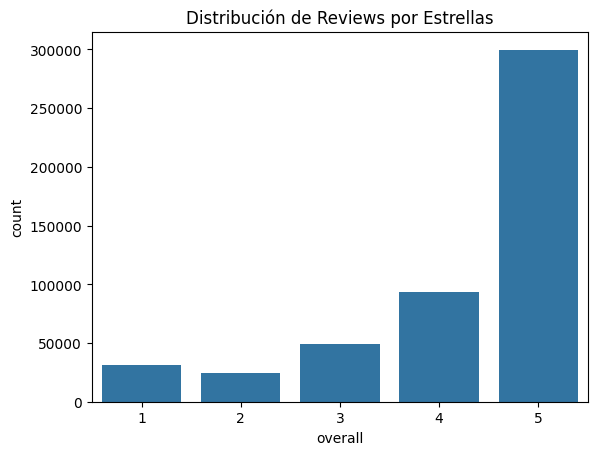

In [7]:
sns.countplot(x='overall', data=df)
plt.title('Distribución de Reviews por Estrellas')
plt.show()

Distribución de reviews positivas (4 o 5 estrellas) y negativas (1, 2 o 3 estrellas)

In [8]:
df['label'] = df['overall'].apply(lambda x: 1 if x >= 4 else 0 if x <= 2 else None)
df = df.dropna(subset=['label'])
print(df['label'].value_counts())

label
1.0    393413
0.0     55018
Name: count, dtype: int64


N-grams más frecuentes

In [9]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['reviewText'].dropna())
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

print("Top 10 bigramas más frecuentes:")
print(words_freq[:10])

Top 10 bigramas más frecuentes:
[('great game', 27939), ('game play', 23598), ('play game', 16215), ('good game', 15351), ('fun game', 14706), ('ve played', 14582), ('playing game', 12848), ('game just', 12845), ('single player', 12236), ('love game', 11958)]


Nube de palabras

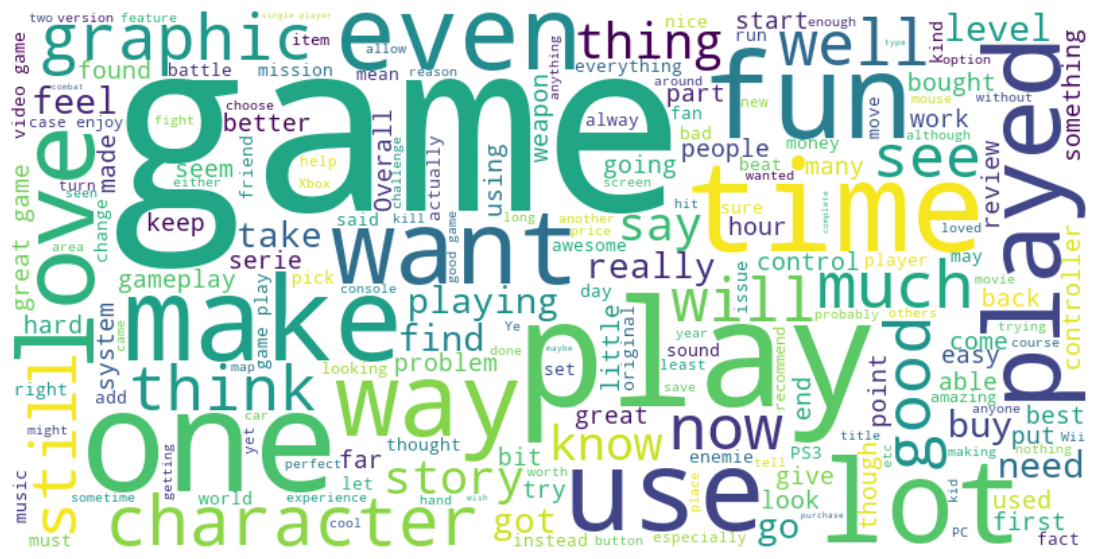

In [10]:
text = " ".join(df['reviewText'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Embeddings con Word2Vec y visualización

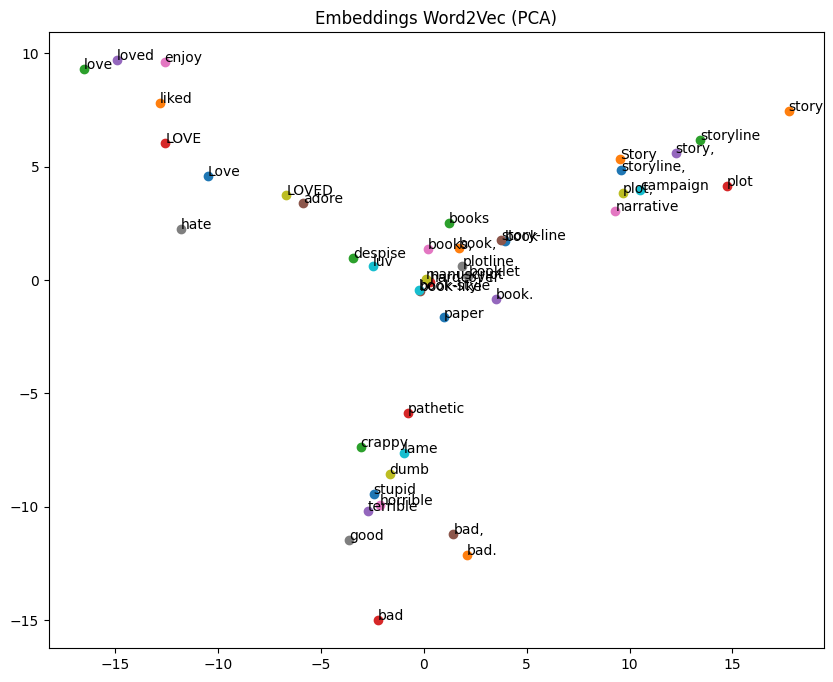

In [11]:
sentences = df['reviewText'].dropna().astype(str).apply(lambda x: x.split()).tolist()
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

words = ['book', 'story', 'love', 'bad']
similar_words = [model.wv.most_similar(w, topn=10) for w in words]

pca = PCA(n_components=2)
words_plot = []
for word, group in zip(words, similar_words):
    words_plot.append(word)
    words_plot.extend([w for w, _ in group])
    
X = pca.fit_transform([model.wv[w] for w in words_plot])

plt.figure(figsize=(10, 8))
for i, word in enumerate(words_plot):
    plt.scatter(X[i, 0], X[i, 1])
    plt.annotate(word, xy=(X[i, 0], X[i, 1]))
plt.title("Embeddings Word2Vec (PCA)")
plt.show()

## Etapa de preprocesado de texto

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

df['clean_text'] = df['reviewText'].dropna().astype(str).apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\migue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df.T

,0,1,3,4,5,6,7,8,9,10,...,497564,497565,497566,497567,497568,497569,497571,497572,497575,497576
overall,5,4,2,5,4,1,5,5,4,4,...,5,5,5,5,5,4,5,4,4,2
verified,True,False,True,True,True,False,True,True,True,True,...,True,True,True,True,True,True,True,True,False,True
reviewTime,"10 17, 2015","07 27, 2015","02 20, 2015","12 25, 2014","11 13, 2014","08 2, 2014","03 3, 2014","02 21, 2014","06 27, 2013","12 28, 2012",...,"04 11, 2018","08 1, 2018","02 22, 2018","09 18, 2017","06 19, 2017","05 28, 2017","07 1, 2017","07 1, 2017","08 5, 2018","03 13, 2018"
reviewerID,A1HP7NVNPFMA4N,A1JGAP0185YJI6,A2204E1TH211HT,A2RF5B5H74JLPE,A11V6ZJ2FVQY1D,A1KXJ1ELZIU05C,A1WK5I4874S3O2,AV969NA4CBP10,A1EO9BFUHTGWKZ,A2M8JTIST6FPZZ,...,A1VK22JLEHMMY8,A213MVKPFZ8SCW,A3JEH3NECE55AB,A1O3GR0TMQEVU8,AVOS4AN9YUGCL,A3P0CBZ9GCL0OU,A2NKYXCAGBGW7F,AVECM71LSZLC5,A34GG58TJ1A3SH,A6W81WTFK940B
asin,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,...,B01HDJFJOM,B01HDJFJLK,B01HFRICLE,B01HFRICLE,B01HFRICLE,B01HFRICLE,B01HGPUTCA,B01HGPUTCA,B01HIZF7XE,B01HIZGKOE
reviewerName,Ambrosia075,travis,Grandma KR,jon,IBRAHIM ALBADI,Creation27,WhiteSkull,Travis B. Moore,johnnyz3,Amazon Customer,...,Amazon Customer,mark r.,Eddie,armyjackson,Jim Y,Anfotero,Snipun1,boris teplitskiy,seamonkey10,msam420
reviewText,"This game is a bit hard to get the hang of, bu...",I played it a while but it was alright. The st...,"found the game a bit too complicated, not what...","great game, I love it and have played it since...",i liked a lot some time that i haven't play a ...,"I'm an avid gamer, but Anno 2070 is an INSULT ...",I bought this game thinking it would be pretty...,I have played the old anno 1701 AND 1503. thi...,"I liked it and had fun with it, played for a w...",4 Stars because they like it and play it often...,...,I have to say for the price it was well worth ...,the kides love this game.,funny game just like the old Nintendo days. it...,This is the RIver City Ransom sequel that I've...,If you played and enjoyed River City Ransom on...,Old school classic,"This Work Great and easy to replace, I would n...",not OEM but good replacement parts,I think I originally began playing Bioshock se...,"The graphics are terrible, it looks like ps2 g..."
summary,but when you do it's great.,"But in spite of that it was fun, I liked it",Two Stars,love this game,Anno 2070,Avoid This Game - Filled with Bugs,A very good game balance of skill with depth o...,Anno 2070 more like anno 1701,Pretty fun,My boys enjoys these strategy games,...,Farming Simulator 17,Five Stars,Five Stars,it has the Dodgeball yard from Super Dodgeball...,Nostalgic Fun,Four Stars,I plan on doing all my controllers this way now,Four Stars,"It's Okay, Nothing Profound",Not as good as I expected it to be
unixReviewTime,1445040000,1437955200,1424390400,1419465600,1415836800,1406937600,1393804800,1392940800,1372291200,1356652800,...,1523404800,1533081600,1519257600,1505692800,1497830400,1495929600,1498867200,1498867200,1533427200,1520899200
vote,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Convierto los Nan de clean_text a string vacio '' para poder entrenar. Me planteo eliminar los clean_text

In [14]:
df[df['clean_text'] == ''].shape[0]

1034

In [15]:
df[df['clean_text'].isna()].shape[0]

152

In [16]:
df['clean_text'] = df['clean_text'].fillna('').astype(str)

In [17]:
df[df['clean_text'].isna()].shape[0]

0

In [18]:
df[df['clean_text'] == ''].shape[0]

1186

Elimino las reviews con clean_text ''

In [19]:
df = df[df['clean_text'].str.strip() != '']

In [20]:
df.T

,0,1,3,4,5,6,7,8,9,10,...,497564,497565,497566,497567,497568,497569,497571,497572,497575,497576
overall,5,4,2,5,4,1,5,5,4,4,...,5,5,5,5,5,4,5,4,4,2
verified,True,False,True,True,True,False,True,True,True,True,...,True,True,True,True,True,True,True,True,False,True
reviewTime,"10 17, 2015","07 27, 2015","02 20, 2015","12 25, 2014","11 13, 2014","08 2, 2014","03 3, 2014","02 21, 2014","06 27, 2013","12 28, 2012",...,"04 11, 2018","08 1, 2018","02 22, 2018","09 18, 2017","06 19, 2017","05 28, 2017","07 1, 2017","07 1, 2017","08 5, 2018","03 13, 2018"
reviewerID,A1HP7NVNPFMA4N,A1JGAP0185YJI6,A2204E1TH211HT,A2RF5B5H74JLPE,A11V6ZJ2FVQY1D,A1KXJ1ELZIU05C,A1WK5I4874S3O2,AV969NA4CBP10,A1EO9BFUHTGWKZ,A2M8JTIST6FPZZ,...,A1VK22JLEHMMY8,A213MVKPFZ8SCW,A3JEH3NECE55AB,A1O3GR0TMQEVU8,AVOS4AN9YUGCL,A3P0CBZ9GCL0OU,A2NKYXCAGBGW7F,AVECM71LSZLC5,A34GG58TJ1A3SH,A6W81WTFK940B
asin,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,0700026657,...,B01HDJFJOM,B01HDJFJLK,B01HFRICLE,B01HFRICLE,B01HFRICLE,B01HFRICLE,B01HGPUTCA,B01HGPUTCA,B01HIZF7XE,B01HIZGKOE
reviewerName,Ambrosia075,travis,Grandma KR,jon,IBRAHIM ALBADI,Creation27,WhiteSkull,Travis B. Moore,johnnyz3,Amazon Customer,...,Amazon Customer,mark r.,Eddie,armyjackson,Jim Y,Anfotero,Snipun1,boris teplitskiy,seamonkey10,msam420
reviewText,"This game is a bit hard to get the hang of, bu...",I played it a while but it was alright. The st...,"found the game a bit too complicated, not what...","great game, I love it and have played it since...",i liked a lot some time that i haven't play a ...,"I'm an avid gamer, but Anno 2070 is an INSULT ...",I bought this game thinking it would be pretty...,I have played the old anno 1701 AND 1503. thi...,"I liked it and had fun with it, played for a w...",4 Stars because they like it and play it often...,...,I have to say for the price it was well worth ...,the kides love this game.,funny game just like the old Nintendo days. it...,This is the RIver City Ransom sequel that I've...,If you played and enjoyed River City Ransom on...,Old school classic,"This Work Great and easy to replace, I would n...",not OEM but good replacement parts,I think I originally began playing Bioshock se...,"The graphics are terrible, it looks like ps2 g..."
summary,but when you do it's great.,"But in spite of that it was fun, I liked it",Two Stars,love this game,Anno 2070,Avoid This Game - Filled with Bugs,A very good game balance of skill with depth o...,Anno 2070 more like anno 1701,Pretty fun,My boys enjoys these strategy games,...,Farming Simulator 17,Five Stars,Five Stars,it has the Dodgeball yard from Super Dodgeball...,Nostalgic Fun,Four Stars,I plan on doing all my controllers this way now,Four Stars,"It's Okay, Nothing Profound",Not as good as I expected it to be
unixReviewTime,1445040000,1437955200,1424390400,1419465600,1415836800,1406937600,1393804800,1392940800,1372291200,1356652800,...,1523404800,1533081600,1519257600,1505692800,1497830400,1495929600,1498867200,1498867200,1533427200,1520899200
vote,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento


In [25]:
df_majority = df[df['label'] == 1]
df_minority = df[df['label'] == 0]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=10)
df_balanced = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=10)

Divido los datos en train y test

In [26]:
X = df_balanced['clean_text']
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [27]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_vec, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [28]:
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     10994
         1.0       0.88      0.88      0.88     10995

    accuracy                           0.88     21989
   macro avg       0.88      0.88      0.88     21989
weighted avg       0.88      0.88      0.88     21989



In [34]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))

Confussion matrix:
[[9713 1281]
 [1325 9670]]


## Reporte de métricas y conclusiones

**SIN hacer balanceo por undersampling y CON vectorización CountVectorizer los resultados son:**

***Naive Bayes:***

               precision    recall  f1-score   support

         0.0       0.69      0.60      0.64     10994
         1.0       0.95      0.96      0.95     78455

    accuracy                           0.92     89449
   macro avg       0.82      0.78      0.80     89449

weighted avg       0.91      0.92      0.92     89449

***Logistic Regression:***

               precision    recall  f1-score   support

         0.0       0.81      0.58      0.68     10994
         1.0       0.94      0.98      0.96     78455

    accuracy                           0.93     89449
   macro avg       0.88      0.78      0.82     89449
   
weighted avg       0.93      0.93      0.93     89449

**CON balanceo por undersampling y vectorización TFIDF los resultados son:**

Logistic Regression:

                precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     10994
         1.0       0.88      0.88      0.88     10995

    accuracy                           0.88     21989
   macro avg       0.88      0.88      0.88     21989
   
weighted avg       0.88      0.88      0.88     21989

Como conclusión me quedo con el balanceo y la vectorización TFIDF ya que balancea los positivos y los negativos